# **NLP Project - Sentiment analysis**
The final goal of this solution is to provide a RNN model that will make the sentiment analysis of twitter messages from the given [training data](https://www.kaggle.com/kazanova/sentiment140/notebooks) of Kaggle.

It implements 4 models (classfiers and RNN models) in the pipeline, allowing comparison and search of the most accurate for a given tweet.

In this notebook, the initial dataset is studied and processed before the creation (then load) of the different models. A condensed use of a model, from a random input tweet to its prediction, is made in the pipeline. Before that, the models are initialized, trained, and tested.

> The pipeline solution is at the end of this notebook.

To access the dynamic table of contents, this toggle icon (top left of google colab notebook) can be used :  image.png

(non dynamic) **Table of Contents** :

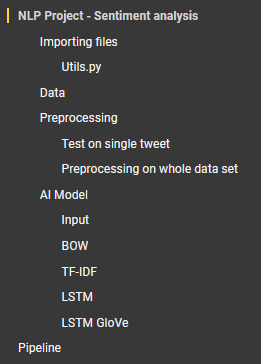

---

We make the import in this one cell at the beginning of the notebook. It has been completed throughout the making of the whole solution.

In [377]:
import pandas as pd
import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import random

# preprocess
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import keras

# rnn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, BatchNormalization, LSTM, SpatialDropout1D, Bidirectional

# classifiers
from sklearn.tree import DecisionTreeClassifier # bow
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from sklearn.ensemble import RandomForestClassifier # tf_idf
from joblib import dump, load # scikit-learn model saving and loading

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split

# yelp api
import requests
import json

# preprocess
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Importing files**

---

Various data are stored and then import from a google drive directory, enabling to save time and computation (save model, data / processed data). 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True) # force remount is used to update 

Mounted at /content/gdrive/


( Cell to import the function from the utils.py script. Replaced by the following *Utils.py* section and cell. )

In [ ]:
# from gdrive.MyDrive.NLP_Project import utils
# from gdrive.MyDrive.NLP_Project.utils import *

##### Utils.py

Originally an externat python script, it has been put here for faster changes and as the section may be collapsed, it remains here. The utils.py script will still be available on the Github repository.

In [ ]:
# Utils for english natural language processing mainly

import numpy as np
import re
import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Abbreviations used in convert_abbrev_in_text function 
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(tweet :str):
    '''
    Convert the abbreviation referenced in this script to supposed meaning in the text.
    Input:
        tweet - text to be cleaned
    Output:
        tweet - cleaned text
    '''
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    
    return ' '.join(t)  

def clean(tweet :str): 
    '''
    Clean the text by replacing contractions, mentions, hashtags, etc.
    Input:
        tweet - text to be cleaned
    Output:
        tweet - cleaned text
    ''' 
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    tweet = re.sub('@[^\s]+', ' ', tweet)
    tweet = re.sub(r'[,!?;-]+', '', tweet)
        
    # ... and ..
    tweet = tweet.replace('...', '')
    if '...' not in tweet:
        tweet = tweet.replace('..', '')
    
    # still unprocessed strings 
    tweet = tweet.replace('%', '')
    tweet = tweet.replace('  ', '')
        
    return tweet    
 
def tokenize(corpus :str):
    '''
    Tokenize the text.
    Input:
        corpus - text to be tokenized
    Output:
        token - tokenized corpus
    '''
    token = nltk.word_tokenize(corpus)  # tokenize string to words
    token = [ch.lower() for ch in token if ch.isalpha()]
    return token    

def clean_one_token(token :str):
    '''
    Remove the stopwords, apply stemmization and lemmization.
    Input:
        token - token to be processed
    Output:
        clean_token - processed tokens
    '''
    # remove stopwords
    cleaned_token = [word for word in token if not word in list(stopwords.words('english'))]
    # revmove too short words (of length 1 or 2)
    cleaned_token = [word for word in cleaned_token if len(word) > 2]
    # stemming
    stemmer = EnglishStemmer()
    cleaned_token = [stemmer.stem(word) for word in cleaned_token]
    # lemming
    Word_Lemmatizer = WordNetLemmatizer()
    cleaned_token = [Word_Lemmatizer.lemmatize(word) for word in cleaned_token]

    if cleaned_token == []:
      cleaned_token = np.nan

    return cleaned_token

def token_clean(tokens :list):
    '''
    Remove the stopwords, apply stemmization and lemmization for a list of tokens.
    Input:
        tokens - all tokens to be processed (list of list)
    Output:
        cleaned_tokens - processed tokens
    '''
    cleaned_tokens = [clean_one_token(tokens[i]) for i in range(len(tokens))]

    return cleaned_tokens

def data_preprocess(data :list):
    '''
    Make the preprocessing on the data (cleaning, tokenizing, stemming and lemming).
    Input:
        data - list of tweets
    Output:
        tokens - processed tokens
    '''
    cleaned_data = [convert_abbrev_in_text(clean(tweet)) for tweet in data]
    tokens = [tokenize(tweet) for tweet in cleaned_data]
    tokens = token_clean(tokens)
    
    return tokens

def get_max_len(tab :list):
  '''
  Get the max length of tab values, tab supposely of dimension 2 at least for meaningful function.
  Input: 
    tab - list of lists
  Output:
    max_len - the max length of the lists
  '''
  max_len = 0
  for item in tab:
    if len(item) > max_len:
      max_len = len(item)
  
  return max_len

def voc_vector(tokens :list):
    '''
    Create the vocabulary vector from the processed tokens.
    Input:
        tokens - processed tokens
    Output:
        voc - vocabulary vector
    '''
    
    voc = [] # vocabulary vector
    for token_list in tokens:
        for word in token_list:
            voc.append(word)

    voc = sorted(set(voc)) # ordered list
    
    return voc

def bags_of_words(tokens : list, voc :list):
    '''
    Create the bags of words of given tokens.
    Inputs:
        tokens
        voc - vocabulary of tokens
    Output:
        bas_of_words
    '''
    
    bags_of_words = []
    for i,token_list in enumerate(tokens):
        bags_of_words.append([])
        freq = dict(nltk.FreqDist(token_list))
        for word in voc:
            if word in freq.keys():
                bags_of_words[i].append(freq[word])
            else:
                bags_of_words[i].append(0)
    
    return bags_of_words

## unused function in final solution but useful for early debbuging
def pad_list(data :list, max_len :int):
  '''
  Pad to the right each list of the given data to the wanted length.
  Inputs:
    data - list of lists to be padded
    max_len - wanted length
  Output:
    padded_tab - padded data
  '''
  padded_data = []
  for token in data:
    if (token == []):
      token.append('<PAD>')
    padded_token = np.pad(token, pad_width=(0, max_len-len(token)), mode='constant', constant_values=('<PAD>'))
    padded_data.append(padded_token)

  return padded_data


### **Data**

---

The data is stored in a gdrive directory and is a labeled csv file. All information are thus retrieved in a DataFrame, then some of the labels are droped since there are of no use to the solution.

In [ ]:
# display original kaggle data
labeled_data = pd.read_csv("gdrive/MyDrive/NLP_Project/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
labeled_data.columns = ["target", "time", "date", "query", "username", "text"]
labeled_data = labeled_data.drop(columns=["time","date","query","username"])

Resuming all information on the resulting DataFrame object :

In [ ]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   text    1599999 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


There are a total of 1,599,999 tweet in this DataFrame, which is great deal of possible training asset. In this solution, all of the tweets would not be used as it may eat all the RAM or simply bring too long computations.

It is now possible to see how the data looks like : tweets as strings and their target sentiment (0 if negative, 4 if positive).

First, the start of the data...

In [ ]:
labeled_data.head()

,target,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


...and then the end.

In [ ]:
labeled_data.tail()

,target,text
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,happy #charitytuesday @theNSPCC @SparksCharity...


Exemple of a tweet that will need to be processed :

In [ ]:
labeled_data['text'][1]

'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'

### **Preprocessing**

This part will take care of the raw data that has been loaded : from simple cleaning to tokenization and usable data.

Moreover, this processing is for english text only.

---

The processing is as follow :

* Take care of the abbreviations and contractions of english words ;
* Tokenize the tweets ;
* Stemming and lemming on the words.

##### Test on single tweet

This part helps to debugg the preprocessing function and see the changes on a tweet.

A random tweet is chosen (arbitrary choice: first tweet) and is cleaned as a string :

In [ ]:
corpus = clean(labeled_data['text'][0]) # pre-clean (contractions, mentions, hashtags, etc.)
corpus = convert_abbrev_in_text(corpus) # pre-clean (known abbreviations)
corpus

'is upset that he cannot update his Facebook by texting it and might cry as a resultSchool today also. Blah'

Then the tweet is tokenized and cleaned afterwards :

In [ ]:
token_corpus = tokenize(corpus) # tokenization
token_corpus = token_clean([token_corpus]) # after-clean (stopwords and other)
token_corpus

[['upset',
  'updat',
  'facebook',
  'text',
  'might',
  'cri',
  'resultschool',
  'today',
  'also',
  'blah']]

##### Preprocessing on whole data set

After trying the different function on a single tweet and maling sure those are working properly, this preprocessing can be done on the whole dataset. It will then be stored as a csv file in a gdrive directory as the computation take a long time to be done.

In [ ]:
def get_processed_data(load_csv=True):
  '''
   Load from the given path the processed data or process the data.
   Inputs:
    path - file path of processed data
    load - bool true if loaded from dir
  Output:
    preprocessed_data - the resulting dataframe
  '''
  if load_csv :
    preprocessed_data = pd.read_csv('gdrive/MyDrive/NLP_Project/cleaned_tweets.csv')
    # Cast to List the text in dataFrame
    preprocessed_data.text = preprocessed_data.text.apply(eval)

  else :
    # Process the initial data 
    tokens = data_preprocess(labeled_data['text'])

    # Create new dataframe with processed data
    preprocessed_data = pd.DataFrame(columns=['target','text'])
    preprocessed_data['target'] = labeled_data['target']  # assign values to corresponding column
    preprocessed_data['text'] = tokens # (is assigned as strings)

    # Remove empty lists
    preprocessed_data.dropna(subset=['text'], inplace=True) # nan values are assigned in the tokenization process if a list is empty
    # Replace 0 by 0 and 4 by 1 for binary target data
    preprocessed_data['target'].replace([4, 0],[1, 0], inplace=True) 
    preprocessed_data.to_csv('gdrive/MyDrive/NLP_Project/cleaned_tweets.csv', index=False)

  return preprocessed_data

The above function is used to load the preprocessed data or to compute it.

In [ ]:
preprocessed_data = get_processed_data(True)

We can then see the data : first tweets...

In [ ]:
preprocessed_data.head()

,target,text
0,0,"[upset, updat, facebook, text, might, cri, res..."
1,0,"[dive, mani, time, ball, manag, save, rest, bo..."
2,0,"[whole, bodi, feel, itchi, like, fire]"
3,0,"[behav, mad, see]"
4,0,"[whole, crew]"


... and last tweets.

In [ ]:
preprocessed_data.tail()

,target,text
1588500,1,"[woke, school, best, feel, ever]"
1588501,1,"[cool, hear, old, walt]"
1588502,1,"[readi, mojo, makeov, ask, detail]"
1588503,1,"[happi, birthday, boo, alll, time, tupac, amar..."
1588504,1,"[happi, charitytuesday]"


We can see that the text data is of List type, as computed.

In [ ]:
type(preprocessed_data.text[0])

list

### **AI Model**

4 models are computed and trained to make the sentiment rpediction on a given tweets : 

* **BOW** : uses the bags of words of a tweet ;
* **TF-IDF** : uses Term Frequency-Inverse Document Frequency of a tweet, giving more information on each words as floats ;
* **LSTM** : Long-Short Term Memory ;
* **LSTM GloVe** : Long-Short Term Memory with use of the Global Vectors for Word Representation dataset.

---

#### Input

This section is to assign the target and input data to X and Y variables, that are then cast to numpy array.

In [ ]:
# Input
X = preprocessed_data.text
X = np.array(X)

# Target of the input
Y = preprocessed_data.target
Y = np.array(Y)

max_len_X = get_max_len(X)
print('input length :', len(X))
print('max length of tweets :', max_len_X)

input length : 1588505
max length of tweets : 30


We reduce length of input to 4000 tweets in order to make the computations. Otherwise, all the RAM will be used and the models would not be able to make their needed calculations.

In [ ]:
# The reduced input takes 2000 negative tweets and 2000 posituve ones
concat_X = np.concatenate((X[:2000], X[-2000:]), axis=None)
print(concat_X[0])
print(concat_X[-1])

# The corresponding target are assembled in a same manner
concat_Y = np.concatenate((Y[:2000], Y[-2000:]), axis=None)
concat_Y[-2000:] = 1
print(concat_Y[0])
print(concat_Y[-1])


max_len_concat_X = get_max_len(concat_X)
print('Max length of a tweet in the reduced input :', max_len_concat_X)

['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'resultschool', 'today', 'also', 'blah']
['happi', 'charitytuesday']
0
1
Max length of a tweet in the reduced input : 19


#### **BOW**

The model using the bags of words representation is a simple classifier : a Desicion Tree.

With a bag of words representation, the words are transposed as a sequence of numbers which is the frequency of each word of the tweet given a vocabulary vector. The vocabulary vectore is obtained on the reduced input data we selected. 

Bags of words

In [ ]:
def load_voc(input_values=-1, is_loaded=True):
  '''
  Load or create the vocabulary vector.
  Inputs:
    is_loaded - True if the vector is loaded from its storage directory
    input_values - input values for vector computation
  Ouput:
    voc - the vocabulary vector as a DataFrame
  '''
  voc = -1
  if is_loaded:
    voc = pd.read_csv('gdrive/MyDrive/NLP_Project/models/bow/voc_vector.csv')

  elif type(input_values)!=int and not is_loaded:
    voc = voc_vector(input_values)

  return voc

In [ ]:
# Vocabulary vector for the bow model from reduced input data
bow_voc = load_voc(input_values=concat_X, is_loaded=False)

# The bags of words representation for each tweet is calculated
bow_X = bags_of_words(concat_X, bow_voc) # X
bow_Y = concat_Y # Y still the same

print('Length of the vocabulaty vector :', len(bow_voc))

Length of the vocabulaty vector : 6798


It is necessary to save the vocabulary vector used by the BOW model since it depends on it. Consequently, in the pipeline this vector will needed to calculate its bag of words representation. 

In [ ]:
# Save to csv the voc vector for use in pipeline
save = False # for safety
if save:
  voc = pd.DataFrame(bow_voc) # cast to DataFrame for csv saving
  voc.to_csv('gdrive/MyDrive/NLP_Project/models/bow/voc_vector.csv', index=False) # save the vocabulary vector as csv in gdrive directory

With preparation done, we can separate the input data in training and validation data. 

In [ ]:
bow_X_train, bow_X_test, bow_Y_train, bow_Y_test = train_test_split(bow_X, concat_Y, random_state = 0) # by default shuffle = True
print('Training data length :', len(bow_X_train))
print('Valdiation data length :', len(bow_X_test))

Training data length : 3000
Valdiation data length : 1000


Afterwards, the model is created and trained on the input we selected.

In [ ]:
def load_bow_clf(is_loaded=True, bow_X_train=-1, bow_Y_train=-1):
  '''
  Load or initialize/fit the BOW classifier.
  Input:
    is_loaded - True if the classifier is loaded from its storage directory
  Output:
    bow_clf - the BOW classifier
  '''
  bow_clf = -1
  if is_loaded:
    bow_clf = load('gdrive/MyDrive/NLP_Project/models/bow/bow_model.joblib')

  elif not is_loaded and type(bow_X_train)!=int and type(bow_Y_train)!=int:
    # Create the classifier model
    bow_clf = DecisionTreeClassifier(random_state=0)
    # Train
    bow_clf.fit(bow_X_train, bow_Y_train)
  
  return bow_clf


In [ ]:
# Load or create/train the classifier model
train = False # for safety
is_load = not train

bow_clf = load_bow_clf(is_load, bow_X_train, bow_Y_train)

The BOW model is saved in a gdrive directory for later use in the pipeline solution.

In [ ]:
if train: # for safety
  dump(bow_clf, 'gdrive/MyDrive/NLP_Project/models/bow/bow_model.joblib')

Predictions can be thus made, giving us an idea of its accuracy and efficiency.

In [ ]:
predictions = bow_clf.predict(bow_X_test)

# Visual mesures of the model
print(confusion_matrix(bow_Y_test,predictions))   #  confusion matrix
print(classification_report(bow_Y_test,predictions))  # report
print(accuracy_score(bow_Y_test, predictions))  # mean accuracy score

[[306 202]
 [150 342]]
              precision    recall  f1-score   support

           0       0.67      0.60      0.63       508
           1       0.63      0.70      0.66       492

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000

0.648


We can also test it on a specific tweet in its bow representation. 

In [ ]:
# Single input test
i = 4 # index of the input
print('Target : ', bow_Y_test[i]) # target 
print(np.array(bow_X_test[i]).reshape(1, -1)[0])
print('Prediction :', bow_clf.predict(np.array(bow_X_test[i]).reshape(1, -1))[0]) # prediction

Target :  0
[0 0 0 ... 0 0 0]
Prediction : 0


#### **TF-IDF**



To calculate the tf-idf of a tweet, the sentence(s) needs to be as one string. Thus, the preprocessed tweets (tokenized and cleaned) are joined together.

In [ ]:
# Re process the tweets dor tf-idf calculations
tf_idf_X = [' '.join(i) for i in concat_X] # concat all token in sentences for classifier
tf_idf_Y = concat_Y

print('Example of an input :', tf_idf_X[0])

Example of an input : upset updat facebook text might cri resultschool today also blah


The TF-IDF converter can be defined (created or loaded) in order to convert the tweet in a tf-idf representation vector.

In [ ]:
def load_tf_idf_converter(is_loaded=True):
  '''
  Load or create the TF-IDF converter.
  Input:
    is_loaded - True if the converter is loaded from its storage directory
  Output:
    The TF-IDF converter
  '''
  tfidfconverter = -1 # to track errors
  if is_loaded:
    tfidfconverter = load('gdrive/MyDrive/NLP_Project/models/tf_idf/tf_idf_converter.joblib')

  else:
    # Create feature vectors containing TF-IDF values
    tfidfconverter = TfidfVectorizer(
        max_features=2000,  # number of most occurring words for which we want to create feature vectors
        min_df=5,           # the word must occur in at least min_df tweets
        max_df=0.7,         # the word must not occur in more than (max_df*100) percent of the tweets
        stop_words=stopwords.words('english')
        )
    
  return tfidfconverter

In [ ]:
# Load or create feature vectors containing TF-IDF values
train = False # for safety
is_load = not train

tfidfconverter = load_tf_idf_converter(is_load)

# Convert your dataset into corresponding TF-IDF feature vectors
tf_idf_X = tfidfconverter.fit_transform(tf_idf_X).toarray() # X = processed tweets from the data

The onverter is stored for later use after it has been created and trained.

In [ ]:
# Save tf_idf converter for later use
if train:
  dump(tfidfconverter, 'gdrive/MyDrive/NLP_Project/models/tf_idf/tf_idf_converter.joblib')

The input data (and target) is split between training and validation data for fitting of the model.

In [ ]:
# Split training and validation data
tf_idf_X_train, tf_idf_X_test, tf_idf_y_train, tf_idf_y_test = train_test_split(tf_idf_X, tf_idf_Y, test_size=0.2, random_state=0)

The model can be now initialized or loaded :

In [ ]:
def load_tf_idf_model(is_loaded=True, tf_idf_X_train=-1, tf_idf_y_train=-1):
  '''
  Load or create the TF-IDF classifier.
  Inputs:
    is_loaded - True if the classifier is loaded from its storage directory
    tf_idf_X_train - input training data for classifier fit
    tf_idf_y_train - input's target training data for classifier fit
  Ouput:
    tf_idf_model - the TF-IDF calssifier
  '''
  tf_idf_clf = -1
  if is_loaded:
    tf_idf_clf = load('gdrive/MyDrive/NLP_Project/models/tf_idf/tf_idf_clf_model.joblib')
  
  elif not is_loaded and type(tf_idf_X_train)!=int and type(tf_idf_y_train)!=int:
    tf_idf_clf = RandomForestClassifier(n_estimators=100, random_state=0)  
    tf_idf_clf.fit(tf_idf_X_train, tf_idf_y_train)
  
  return tf_idf_clf

In [ ]:
# Load or create the TF-IDF classifier
tf_idf_classifier = load_tf_idf_model(is_load, tf_idf_X_train, tf_idf_y_train)

After loading or training, we can make predictions on the test data, as well as visualsing the results.

In [ ]:
# Predictions on the test data
predictions = tf_idf_classifier.predict(tf_idf_X_test)

# Visual mesures of the model
print(confusion_matrix(tf_idf_y_test,predictions))  
print(classification_report(tf_idf_y_test,predictions))  
print(accuracy_score(tf_idf_y_test, predictions))

[[253 154]
 [111 282]]
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       407
           1       0.65      0.72      0.68       393

    accuracy                           0.67       800
   macro avg       0.67      0.67      0.67       800
weighted avg       0.67      0.67      0.67       800

0.66875


We can also make single prediction and see what is the sentiment (0/1) predicted.

In [ ]:
# Single tests

i = 6 # index in the predictions
print('Target :', tf_idf_y_test[i]) # target value
print('Prediction :', tf_idf_classifier.predict(tf_idf_X_test[i].reshape(1, -1))[0]) # prediction value

Target : 0
Prediction : 0


The classifier is saved (stored in gdrive directory) after the end of its training for a later use in the pipeline solution.

In [ ]:
if train: # for safety
  dump(tf_idf_classifier, 'gdrive/MyDrive/NLP_Project/models/tf_idf/tf_idf_clf_model.joblib')

#### **LSTM**

This LSTM model is a RNN model that has feedback connections. It is known that LSTM models are more effective than Deep Neural Networks and conventional RNNs for sentiment analysis. In fact, LSTM (long short term memory) save the words and predict the next words based on the previous words. LSTM is a sequance predictor of next coming words. 

For this model, we will be using another representation of the input data. The data is passed through a Tokenizer that will convert the tweet into float arrays, padded to a chosen max length. It is composed of float giving more a less meaning to each word given the vocabulary vector and other tweet from the input. 

In [ ]:
def load_tokenizer(voc_size=-1, input_values=-1, is_loaded=True):
  '''
  Load or create the Tokenizer.
  Inputs:
    is_loaded - Tru if the Tokenizer is loaded from directory
    voc_size - the vocabulary vector's length
    input_values - input values for Tokenizer fit
  Output:
    tok - Tokenizer
  '''
  tok = -1
  if is_loaded:
    tok = load('gdrive/MyDrive/NLP_Project/models/lstm/tokenizer.joblib')

  elif not is_loaded and voc_size!=-1 and type(input_values)!=int:
    tok = Tokenizer(num_words=voc_size)
    tok.fit_on_texts(input_values)

  return tok

We calculate the vocabulary vector and load (or create / fit) the tokenizer for the input representation. 

In [ ]:
# Converting the text words into float arrays
voc = load_voc(input_values=concat_X, is_loaded=True) # load from drive
voc_size = len(voc)

max_len = 50 # to be a bit large 
tok = load_tokenizer(voc_size=voc_size, input_values=concat_X, is_loaded=True) # load from drive

sequences = tok.texts_to_sequences(concat_X) # the tweet to sequences
padded_sequences = sequence.pad_sequences(sequences,maxlen=max_len) # pad the obtained sequences

print('Padded sequences shape :', padded_sequences.shape)

Padded sequences shape : (4000, 50)


The Tokenizer is saved in a directory after its creation and training for later use in the pipeline solution.

In [ ]:
save = False # prevent misclicks 
if save:
  dump(tok, 'gdrive/MyDrive/NLP_Project/models/lstm/tokenizer.joblib')

The input dataset is split between training and validation data :

In [370]:
lstm_X_train, lstm_X_test, lstm_Y_train, lstm_Y_test = train_test_split(padded_sequences, concat_Y, test_size=0.3, random_state=2)

The model is then defined (loaded or created) for possible training and use.

In [ ]:
def initialize_lstm_model(voc_size :int, max_len :int):
  '''
  Initialize the LSTM model.
  Inputs:
    voc_size - vocabulary vector length
    max_len - supposed maximum length of a tweet for padding
  Output:
    model - the keras model
  '''
  model = keras.Sequential([
      Input(shape=[max_len]),
      Embedding(voc_size,50,input_length=max_len),
      LSTM(64),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(1,activation='sigmoid')
      ])
  return model

def load_lstm_model(is_loaded=True, voc_size=-1, max_len=-1):
  '''
  Initialize the LSTM model or load it from directory.
  Inputs:
    is_loaded - True if the LTSM model is loaded for its storage directory
    voc_size - vocabulary vector length
    max_len - supposed maximum length of a tweet for padding
  Output:
    model - the keras model
  '''
  model = -1
  if is_loaded:
    model = keras.models.load_model('gdrive/MyDrive/NLP_Project/models/lstm/lstm_model')

  elif not is_loaded and voc_size!=-1 and max_len!=-1:
    model = initialize_lstm_model(voc_size, max_len)

  return model

In [ ]:
lstm_model = load_lstm_model(is_loaded=True, voc_size=voc_size, max_len=max_len)

rmsprop_opt = keras.optimizers.RMSprop(learning_rate=0.1)
lstm_model.compile(
    loss = 'binary_crossentropy', # 2 classes
    optimizer=rmsprop_opt,
    metrics = ['accuracy']
    )

print(lstm_model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 50)            348300    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 394,637
Trainable params: 394,637
Non-trainable params: 0
_________________________________________________________________
None


The model is trained on 200 epochs total.

In [ ]:
# Training the model
train = False
if train:
  lstm_history = lstm_model.fit(
      lstm_X_train, lstm_Y_train,
      batch_size=80,
      epochs=200, 
      validation_data=(lstm_X_test, lstm_Y_test)
      #validation_split=0.1
      )

Epoch 1/200
35/35 [==============================] - 4s 70ms/step - loss: 4.6974 - accuracy: 0.8147 - val_loss: 5.3023 - val_accuracy: 0.7050
Epoch 2/200
35/35 [==============================] - 2s 53ms/step - loss: 1.1557 - accuracy: 0.8292 - val_loss: 3.3490 - val_accuracy: 0.7100
Epoch 3/200
35/35 [==============================] - 2s 54ms/step - loss: 0.7366 - accuracy: 0.8382 - val_loss: 1.7259 - val_accuracy: 0.7183
Epoch 4/200
35/35 [==============================] - 2s 54ms/step - loss: 0.7129 - accuracy: 0.8243 - val_loss: 2.3029 - val_accuracy: 0.7000
Epoch 5/200
35/35 [==============================] - 2s 54ms/step - loss: 0.5598 - accuracy: 0.8332 - val_loss: 2.7978 - val_accuracy: 0.7158
Epoch 6/200
35/35 [==============================] - 2s 54ms/step - loss: 0.4724 - accuracy: 0.8490 - val_loss: 2.6590 - val_accuracy: 0.7233
Epoch 7/200
35/35 [==============================] - 2s 54ms/step - loss: 0.5505 - accuracy: 0.8502 - val_loss: 2.3677 - val_accuracy: 0.7075
Epoch 

Once trained, the accuracy can be tested through the validation data.

In [ ]:
# Testing the model
lstm_accuracy = lstm_model.evaluate(lstm_X_test, lstm_Y_test)

38/38 [==============================] - 1s 10ms/step - loss: 25.3148 - accuracy: 0.6808


Predictions of the validation data are made :

On the whole set

In [ ]:
lstm_predictions = lstm_model.predict(lstm_X_test)

Or on single tweets from the set

In [ ]:
for i in range(10):
  print(lstm_Y_test[i], '  /   {:0.2f}'.format(lstm_predictions[i][0]))

1   /   1.00
0   /   0.00
0   /   0.00
1   /   1.00
1   /   0.94
1   /   0.00
0   /   1.00
1   /   1.00
0   /   0.00
0   /   1.00


With the history of the training, the results can be plot as graphs. We have thus a better understanding with visuals.

In [ ]:
def plot_history(history):
  '''
  Plot the fit history of a model.
  Input:
    history - fit history of a model
  '''
  # Retrieve a list of list results on training and test data sets for each training epoch
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(len(acc)) # Get number of epochs

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, acc, 'r')
  plt.plot(epochs, val_acc, 'b')
  plt.title('Training and validation accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Accuracy", "Validation Accuracy"])

  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss, 'r')
  plt.plot(epochs, val_loss, 'b')
  plt.title('Training and validation loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Loss", "Validation Loss"])

  plt.figure()

  return

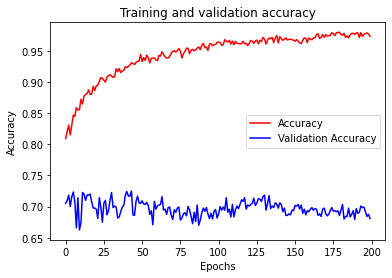

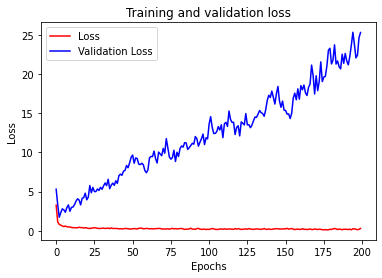

<Figure size 432x288 with 0 Axes>

In [ ]:
# Fitting summary in graphs
plot_history(lstm_history)

Finally, the model is saved to directory for prediction use in the pipeline

In [ ]:
save = False # prevent misclicks 
if save:
  lstm_model.save('gdrive/MyDrive/NLP_Project/models/lstm/lstm_model')

#### **LSTM GloVe**

The idea is the same has the LSTM model since it uses the same LSTM layers, but in addition GloVe Embedding (Global Vectors for Word Representations) layer is used. 

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. It gives us in this manner a more meaningful representation of the tweets.

The Embedding layer used in the model is computed thanks to the GloVe dataset.

In [ ]:
def read_glove_vector(path :str):
  '''
  Read the GloVe vector file from its text file.
  Input:
    path - path of the glove file
  Output:
    word_to_vec_map - dictionnary that maps the words with their respective word embeddings
  '''
  with open(path, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec_map

We already have the Tokenizer of max length 50 and max word 5000., and we reuses the data obtained after training and validation split for the previous LSTM model.

In [ ]:
# Calculate the Embedding layer's parameters 
tok = load_tokenizer()
voc = load_voc()
voc_size = len(voc)

words_to_index = tok.word_index # for embedding matrix computation

word_to_vec_map = read_glove_vector('gdrive/MyDrive/NLP_Project/models/lstm/glove.6B.50d.txt') # where glove makes its entrance
embed_vec_len = word_to_vec_map['moon'].shape[0] # random pick to get length

emb_matrix = np.zeros((voc_size, embed_vec_len)) # enbedding matrix initialization
# Compution embedding matrix
for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

The model is defined (either initialized or loaded) with the following cells. Two version of the LSTM model base on GloVe since its accuracy is very low. The reason for this low accuracy no matter the layers is still unknown. 

Here the model is according to the version 2.

In [ ]:
def initialize_lstm_glove_model_v1(voc_size :int, max_len :int, embed_vec_len :int, emb_matrix :list):
  '''
  Initialize an LSTM model based on the GloVe dataset.
  Version 1.
  Inputs:
    voc_size - vocabulary vectore length
    max_len - supposed maximum input length
    embed_vec_len - length of the embedding vector
    emb_matrix - embedding matrix (weights)
  Output:
    model - the GloVe LSTM based model
  '''
  model = keras.Sequential([
      Input(shape=[max_len]),
      Embedding(input_dim=voc_size, output_dim=embed_vec_len, input_length=max_len, weights=[emb_matrix], trainable=True),
      LSTM(128, return_sequences=True),
      Dropout(0.6),
      LSTM(128, return_sequences=True),
      Dropout(0.6),
      LSTM(128),
      Dense(1,activation='sigmoid')
  ])
  return model

# Actual version used in following computation (see load_lstm_model function)
def initialize_lstm_glove_model_v2(voc_size :int, max_len :int, embed_vec_len :int, emb_matrix :list):
  '''
  Initialize an LSTM model based on the GloVe dataset.
  Version 2.
  Inputs:
    voc_size - vocabulary vectore length
    max_len - supposed maximum input length
    embed_vec_len - length of the embedding vector
    emb_matrix - embedding matrix (weights)
  Output:
    model - the GloVe LSTM based model
  '''
  model = keras.Sequential()
  model.add(Embedding(input_dim=voc_size, output_dim=embed_vec_len, input_length=max_len, weights=[emb_matrix], trainable=True),)
  model.add(SpatialDropout1D(0.25))
  model.add(Bidirectional(LSTM(128,return_sequences=True)))
  model.add(Bidirectional(LSTM(64,return_sequences=False)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  return model

def load_lstm_model(is_loaded=True, voc_size=-1, max_len=-1, embed_vec_len=-1, emb_matrix=-1):
  '''
  Load or create the GloVe LSTM based model.
  Inputs:
    is_loaded - True if the model is loaded from its storage directory
    voc_size - vocabulary vectore length
    max_len - supposed maximum input length
    embed_vec_len - length of the embedding vector
    emb_matrix - embedding matrix (weights)
  Output:
    model - the GloVe LSTM based model
  '''
  model = -1
  if is_loaded:
    model = keras.models.load_model('gdrive/MyDrive/NLP_Project/models/lstm/lstm_glove_model')

  elif not is_loaded and voc_size!=-1 and max_len!=-1 and embed_vec_len!=-1 and type(emb_matrix)!=int:
    model = initialize_lstm_glove_model_v2(voc_size, max_len, embed_vec_len, emb_matrix)

  return model

We define the model and compile it.

In [ ]:
lstm_glove_model = load_lstm_model(is_loaded=False, voc_size=voc_size, max_len=max_len, embed_vec_len=embed_vec_len, emb_matrix=emb_matrix)

rmsprop_opt = keras.optimizers.RMSprop(learning_rate=0.1)
adam_opt = keras.optimizers.Adam(learning_rate = 0.0001)
lstm_glove_model.compile(
    loss = 'binary_crossentropy', # 2 classes
    optimizer = rmsprop_opt,
    metrics = ['accuracy']
    )

print(lstm_glove_model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 50, 50)            339900    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 50, 256)           183296    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 687,677
Trainable params: 687,677
Non-trainable params: 0
_______________________________________________

In [371]:
# Training the model (same data that previous lstm split)
train = False # prevent misclicks 
if train:
  lstm_glove_history = lstm_glove_model.fit(
      lstm_X_train, lstm_Y_train,
      batch_size=64,
      epochs=10,
      validation_data=(lstm_X_test, lstm_Y_test)
      )

Epoch 1/10
44/44 [==============================] - 19s 431ms/step - loss: 1.4968 - accuracy: 0.5054 - val_loss: 1.7337 - val_accuracy: 0.4983
Epoch 2/10
44/44 [==============================] - 17s 395ms/step - loss: 1.3393 - accuracy: 0.5071 - val_loss: 1.7938 - val_accuracy: 0.4983
Epoch 3/10
44/44 [==============================] - 17s 395ms/step - loss: 1.1978 - accuracy: 0.5014 - val_loss: 0.9242 - val_accuracy: 0.5017
Epoch 4/10
44/44 [==============================] - 17s 398ms/step - loss: 0.8583 - accuracy: 0.4932 - val_loss: 0.7497 - val_accuracy: 0.4983
Epoch 5/10
44/44 [==============================] - 17s 395ms/step - loss: 0.9016 - accuracy: 0.5089 - val_loss: 0.7940 - val_accuracy: 0.4983
Epoch 6/10
44/44 [==============================] - 18s 403ms/step - loss: 0.8384 - accuracy: 0.5250 - val_loss: 1.1746 - val_accuracy: 0.4983
Epoch 7/10
44/44 [==============================] - 17s 394ms/step - loss: 0.7566 - accuracy: 0.5882 - val_loss: 0.7086 - val_accuracy: 0.5767

In [372]:
# Testing the model
lstm_accuracy = lstm_model.evaluate(lstm_X_test, lstm_Y_test)

38/38 [==============================] - 0s 10ms/step - loss: 36.8557 - accuracy: 0.5725


In [373]:
lstm_glove_predictions = lstm_glove_model.predict(lstm_X_test)

# Tests on few tweets to see prediction
for i in range(10):
  print(lstm_Y_test[i], '  /   {:0.2f}'.format(lstm_glove_predictions[i][0]))

1   /   0.56
0   /   0.12
0   /   0.37
1   /   0.33
1   /   0.17
1   /   0.53
0   /   0.38
1   /   0.07
0   /   0.39
0   /   0.17


Moreover, fit history of the model is plot to have a better look on the model evolution.

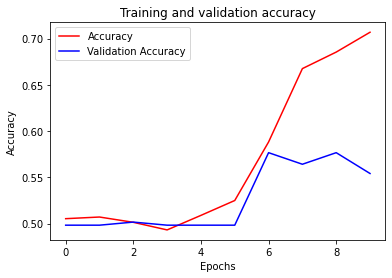

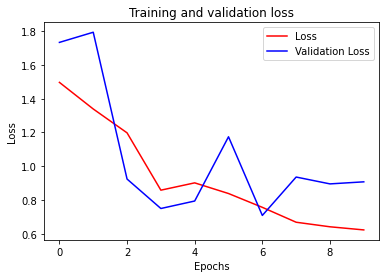

<Figure size 432x288 with 0 Axes>

In [374]:
plot_history(lstm_glove_history)

In [375]:
if train: # prevent misclicks 
  lstm_glove_model.save('gdrive/MyDrive/NLP_Project/models/lstm/lstm_glove_model')

# **Pipeline**

This is the final solution, a pipeline that takes a tweet as input and a classifier/model name to use, and return the sentiment predicted (either positive or negative).

Depending on the model used, it may take more a less time.

In [379]:
def pipeline(tweet :str, model_type='last', model_dir_name='gdrive/MyDrive/NLP_Project/models'):
  '''
  Pipeline for sentiment analysis on tweet.
  Will make a prediction on whether it is positive or negative.
  A specific model may be chose between few one.
  Inputs:
    tweet - the tweet to be analysed
    model_type - name of the type of model to use (bow | tf_idf | lstm | lstm_glove | last)
            'last' will use the last model, thus the more advanced one in calculations
  Output:
    sentiment - the target prediction (positive | negative)
  '''
  preprocessed_tweet = data_preprocess([tweet])[0] # tokenized and cleaned
  # print(preprocessed_tweet)
  prediction = -1 # init, should be 0 or 1 otherwise an error has occured

  if model_type == 'bow':
    # bow of the tweet
    voc = pd.read_csv(model_dir_name + '/bow/voc_vector.csv') # load vocabulary vector
    voc = list(voc['0']) # cast to list
    bow_tweet = bags_of_words([preprocessed_tweet], voc) # do the bags of words of the given tweet
    bow_model = load(model_dir_name + '/bow/bow_model.joblib') # load model
    prediction = bow_model.predict(np.array(bow_tweet).reshape(1, -1))[0] # make the prediction

  elif model_type == 'tf_idf':
    tf_idf_converter = load(model_dir_name + '/tf_idf/tf_idf_converter.joblib') # load tf_idf converter
    tf_idf_classifier = load(model_dir_name + '/tf_idf/tf_idf_clf_model.joblib') # load model
    joined_tweet = ' '.join(preprocessed_tweet) # join the cleaned token for tf-idf conversion
    tf_idf_tweet = tf_idf_converter.transform([joined_tweet]).toarray() # tf_idf of the tweet
    prediction = tf_idf_classifier.predict(np.array(tf_idf_tweet).reshape(1, -1)) # model prediction

  elif model_type == 'lstm':
    tokenizer = load(model_dir_name + '/lstm/tokenizer.joblib') # load tokenizer
    max_len = 50
    tweet_sequence = tok.texts_to_sequences([preprocessed_tweet]) # to sequence
    padded_tweet_sequence = sequence.pad_sequences(tweet_sequence, maxlen=max_len) # padded sequence to match max_length
    ltsm_model = keras.models.load_model(model_dir_name + '/lstm/lstm_model')
    prediction = ltsm_model.predict(padded_tweet_sequence[0].reshape(1, -1)) # make the prediction, rounded to be a binary result
    prediction = round(prediction[0][0])

  elif model_type == 'lstm_glove' or model_type == 'last':
    tokenizer = load(model_dir_name + '/lstm/tokenizer.joblib') # load tokenizer
    max_len = 50 # max length of tweet, for input formatting
    tweet_sequence = tok.texts_to_sequences([preprocessed_tweet]) # to sequence
    padded_tweet_sequence = sequence.pad_sequences(tweet_sequence, maxlen=max_len) # padded sequence to match max_length
    lstm_glove_model = keras.models.load_model(model_dir_name + '/lstm/lstm_glove_model') # load the model
    prediction = lstm_glove_model.predict(padded_tweet_sequence[0].reshape(1, -1)) # make the prediction, rounded to be a binary result
    prediction = round(prediction[0][0])

  # Sentiment determination
  if prediction == -1:
    sentiment = 'error'
  elif prediction == 0:
    sentiment = 'negative'
  elif prediction == 1:
    sentiment = "positive"

  return sentiment

We can test the pipeline and the different model with custom tweets where we know the sentiment

In [380]:
# Created positive an nagative tweets for test
neg_tweet = 'I dont like sweet. it make me feel so gross and fat, eww'
pos_tweet = 'Seems like it a nice day but it could be even more something special if you were there'

# Choose a model from available ones (bow | tf_idf | lstm | lstm_glove | last)
model_type = 'lstm_glove' # (lstm_glove is very long, it is normal)

print(pipeline(neg_tweet, model_type= model_type))
print(pipeline(pos_tweet, model_type= model_type))

negative
positive


The YELP API is used to test the pipeline with random reviews that hold a certain sentiment. The target sentiments are not determined but the user will be the one to judge.

In [384]:
def get_random_review(api_key :str):
  '''
  Get a random review from the YELP API.
  Input:
    api_key - your yelp api key
  '''
  headers = {'Authorization': 'Bearer %s' % api_key}

  url = 'https://api.yelp.com/v3/businesses/search'
  params = {'term':'bookstore','location':'New York City'}

  req = requests.get(url, params=params, headers=headers)
  parsed = json.loads(req.text)

  businesses = parsed["businesses"]
  business = random.choice(businesses)
  id = business["id"]

  url="https://api.yelp.com/v3/businesses/" + id + "/reviews"
  req = requests.get(url, headers=headers)
  parsed = json.loads(req.text)
  reviews = parsed["reviews"]

  return random.choice(reviews)["text"]


With a random generation of the tweet / review, we can test on an unknown data the solution !

In [390]:
api_key = 'kwGY6U2egRIedk4rOL1wG3zNplFJiEULWPc9tkIWVlb2NQumhMm3EKxo1yKrXFmoo7fl4YXZ7MMj5KSDqN-j7b_LTUvOsVjZgAdDoEMtlFqeG90iwTVUV8hmUbM7YHYx' # 'copy_your_yelp_api_key_here'
review = get_random_review(api_key=api_key)
model_type = 'bow' # (bow | tf_idf | lstm | lstm_glove | last)

print(review)
print('Predicted sentiment with', model_type, ' :', pipeline(review))

I stopped in yesterday. There's only one person working, sitting behind a desk. At one point while I was browsing I felt my sock slipping down into my...
Predicted sentiment with bow  : negative


---

We can conclude that this pipeline solution may need some improvements but is still rather satisfying for a student project.